<center><font color="4466ff"> <h1>AutoDL Code</h1> </font></center>
     

# Important To Know

* Target applications of multi-label image classification. 
* Raw data are provided, in TFRecord format.  
* Restrictions are imposed on training time
* This notebook uses sample data. Download Larger datasets from the website as mentioned in ReadMe. 

In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
inges_dir = 'Ingestion/'           # Ingestion program directory
score_dir = 'Scoring/'             # Scoring program directory
baseline_dir = 'Models/Best_model'   # Model is implemented HERE
model_dir = 'current_model/'

output_dir = 'Scoring_output' ## Where the output is saved
detailed_results_page = join(output_dir, 'detailed_results.html')

from sys import path; 
path.append(inges_dir); path.append(score_dir); path.append(model_dir);

# Part 1: Dataset Overview

<font color='red'>Let's start with a sample dataset miniciao, which can be found in <code>./AutoDL_sample_data/miniciao</code>

In [3]:
data_dir = 'AutoDL_sample_data'            # Change this directory and the dataset as needed
data_name = 'miniciao'
!ls $data_dir

Monkeys  miniciao


In [4]:
# read train / test datasets
from dataset import AutoDLDataset # The module 'dataset' is defined at AutoDL_ingestion_program/dataset.py
D_train = AutoDLDataset(join(data_dir, data_name + '/' + data_name + '.data', "train"))
D_test = AutoDLDataset(join(data_dir, data_name + '/' + data_name + '.data', "test"))

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# show important meta information about the dataset
print ("Dataset path: ", D_train.get_metadata().get_dataset_name())
print ("Image shape: ",  D_train.get_metadata().get_tensor_size(0))
print ("Dataset size: ", D_train.get_metadata().size())
print ("Output size: ",  D_train.get_metadata().get_output_size())
print ("Class labels: ", D_train.get_class_labels())

Dataset path:  AutoDL_sample_data/miniciao/miniciao.data/train
Image shape:  (32, 32, 3)
Dataset size:  82
Output size:  10
Class labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


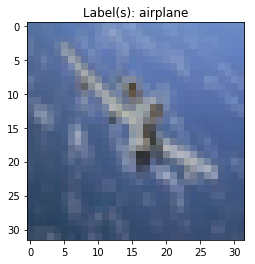

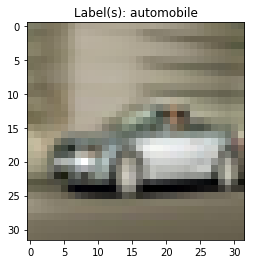

In [6]:
# show sample images
D_train.show_image(1);
D_train.show_image(11);

# Part 2: Model, Prediction and Metrics

In [7]:
# Make a copy of the model to use
model_simple = join(baseline_dir, 'model.py') # choose one simple baseline model
model_submit = join(model_dir, 'model.py') # Location to save the model.py
!cp $model_simple $model_submit

In [8]:
# set time budget and instanciate the model with dataset
from model import Model
time_budget=200
M = Model(D_train.get_metadata())

In [9]:
# train the model for a certain time
M.train(D_train.get_dataset(), remaining_time_budget=time_budget)

2020-03-13 21:36:15,346 INFO model.py: Counting number of examples on train set.
2020-03-13 21:36:15,671 INFO model.py: Finished counting. There are 82 examples for training set.
2020-03-13 21:36:15,672 INFO model.py: Model already trained for 0.0000 epochs.
2020-03-13 21:36:15,673 INFO model.py: Begin training for another 10 steps...
2020-03-13 21:36:15,688 INFO model.py: Tensor shape before preprocessing: (1, 32, 32, 3)
2020-03-13 21:36:15,688 INFO model.py: Tensor shape after preprocessing: (1, 32, 32, 3)
2020-03-13 21:36:17,584 INFO model.py: 10 steps trained. 1.91 sec used. Now total steps trained: 10. Total time used for training + test: 0.00 sec. 


In [10]:
# Part 3: Test

In [11]:
# get prediction by calling test method
prediction = M.test(D_test.get_dataset(), remaining_time_budget=time_budget)

2020-03-13 21:36:17,595 INFO model.py: Counting number of examples on test set.
2020-03-13 21:36:17,830 INFO model.py: Finished counting. There are 18 examples for test set.
2020-03-13 21:36:17,830 INFO model.py: Begin testing...
2020-03-13 21:36:17,841 INFO model.py: Tensor shape before preprocessing: (1, 32, 32, 3)
2020-03-13 21:36:17,842 INFO model.py: Tensor shape after preprocessing: (1, 32, 32, 3)
2020-03-13 21:36:18,307 INFO model.py: [+] Successfully made one prediction. 0.48 sec used. Duration used for test: 0.476486


<font color='red'> For each prediction made at a timestamp $t$, we compute for each (binary) class i the [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic): **$AUC_i$**, then normalize it (and average over all classes) by: 
\begin{equation*}
AUC = \frac{1}{C} \sum_{i=1}^C AUC_i, \quad NAUC = 2 \times AUC - 1,
\end{equation*}

$NAUC$ is also called Gini index in some context. Then, the learning curve can be plot as a function of **$NAUC$** vs. time. Let's denote the learning curve as $s(t)$. Since $s(t)$ is defined as the $NAUC$ of the most recent prediction made before timestamp $t$, $s(t)$ is actually a **step function**.

As this challenge aims to push forward the state-of-the-art in the **any-time learning** setting, we use a performance metric related to the whole learning curve (instead of only the last point). This metric is computed as follows.
- In order to normalize time interval [0, T] to the [0, 1] interval, we perform a time transformation by
  $$\tilde{t}(t) = \frac{\log (1 + t / t_0)}{\log( 1 + T / t_0)}$$
  where $T$ is the time budget (of default value 1200 seconds = 20 minutes) and $t_0$ is a reference time amount (of default value 60 seconds).
- Then we compute the area under learning curve using the formula
  \begin{equation*}
    \begin{aligned}
    ALC &= \int_0^1 s(t) d\tilde{t}(t) \\
    &= \int_0^T s(t) \tilde{t}'(t) dt \\
    &= \frac{1}{\log (1 + T/t_0)} \int_0^T \frac{s(t)}{ t + t_0} dt \\
    \end{aligned} 
  \end{equation*}
  we see that $s(t)$ is weighted by $1/(t + t_0)$, giving a stronger importance to predictions made at the beginning of th learning curve.

This gives the evaluation score used for one task. Later, when ALC score is computed for all tasks, the final score is obtained by the average rank (over all tasks). It should be emphasized that multi-class classification metrics are not being considered, i.e., each class is scored independently.

Let's see in the following how the scores are computed.

In [12]:
# calculate scores
from score import autodl_auc, accuracy
from libscores import read_array
solution_file = join(data_dir, data_name + '/' + data_name + '.solution')
solution = read_array(solution_file)

acc = accuracy(solution, prediction) # note that accuracy is not evaluation metric in the challenge
current_bac = autodl_auc(solution, prediction)
# print('Number of test examples: %d \n\t\t Solution \t\t\t\t\t Prediction ' % len(solution))
# [print(z) for z in zip(solution, prediction)]
print ("Classification Accuracy: ", acc)
print ("Normalized Area Under ROC Curve (NAUC) = {:.4f}.".format(current_bac))
print ("ALC can be read from the result page as shown in the next part.")

2020-03-13 21:36:18,443 INFO score.py: Some columns in solution have only one class, ignoring these columns for evaluation.
Classification Accuracy:  0.06338316830806434
Normalized Area Under ROC Curve (NAUC) = 0.0668.
ALC can be read from the result page as shown in the next part.


In [13]:
# result report
from IPython.core.display import display, HTML

display(HTML(detailed_results_page))